In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("project_datasets/data_A.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312657 entries, 0 to 312656
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   DeviceId  312657 non-null  object 
 1   EventDt   312657 non-null  object 
 2   Temp      312657 non-null  float64
dtypes: float64(1), object(2)
memory usage: 7.2+ MB


Working with time-series formats would require us to do some fixing to our dataframe.
As we can observe the DateTime formatted "EventDt" is read as object.
The dataframe bellow isnt plotting correctly since we aren't using the expected dataset format.

<AxesSubplot:>

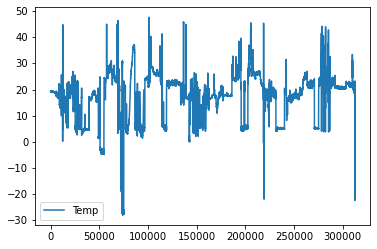

In [4]:
df.plot()

### Fixing the broken Datetime format (Oject to DateTime)

In [5]:
df['EventDt'] = pd.to_datetime(df['EventDt'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312657 entries, 0 to 312656
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   DeviceId  312657 non-null  object        
 1   EventDt   312657 non-null  datetime64[ns]
 2   Temp      312657 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 7.2+ MB


### There is no null values

<AxesSubplot:>

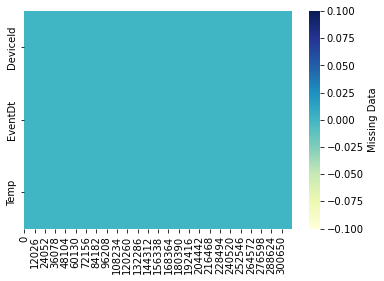

In [6]:
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

In [7]:
df

,DeviceId,EventDt,Temp
0,A,2018-11-18 16:12:19.437,19.41
1,A,2018-11-18 16:17:19.430,19.39
2,A,2018-11-18 16:22:19.433,19.37
3,A,2018-11-18 16:27:19.430,19.41
4,A,2018-11-18 16:32:19.427,19.39
...,...,...,...
312652,A,2021-11-18 15:44:37.000,21.90
312653,A,2021-11-18 15:49:37.000,21.83
312654,A,2021-11-18 15:54:37.007,21.73
312655,A,2021-11-18 15:59:36.997,21.64


### We use the datetime timestamp as an index

A common practice when working with time-series data and analysis

In [8]:
datetime_series = pd.to_datetime(df['EventDt'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
df=df.set_index(datetime_index)
df.drop('EventDt',axis=1,inplace=True)
df

,DeviceId,Temp
2018-11-18 16:12:19.437,A,19.41
2018-11-18 16:17:19.430,A,19.39
2018-11-18 16:22:19.433,A,19.37
2018-11-18 16:27:19.430,A,19.41
2018-11-18 16:32:19.427,A,19.39
...,...,...
2021-11-18 15:44:37.000,A,21.90
2021-11-18 15:49:37.000,A,21.83
2021-11-18 15:54:37.007,A,21.73
2021-11-18 15:59:36.997,A,21.64


<AxesSubplot:>

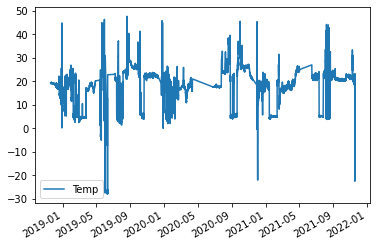

In [9]:
df.plot()

Now that the dataframe is plotted correctly we can easily see where we have some data anomalies
- Extreme Temperature changes
- DataTime gaps that seem to be filled in with Linear interpolations
  (We might need to go back and predict these gaps with a model we train)

## DAIA Part

- Fixing all this would take too long for now im just tesing
- I will just take a sample from the beginning till mid 2019 since the devices seems to be working normally till then

<AxesSubplot:>

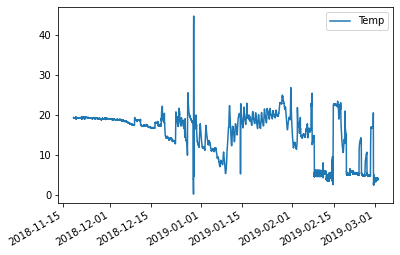

In [10]:
df_a = df.loc['2018-11-18':'2019-03-01']
df_a.shape
df_a.plot()

## Prediction

<AxesSubplot:>

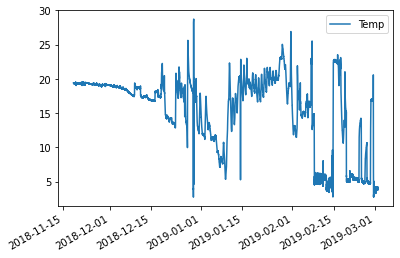

In [11]:
## Remove the outlier in our sample
cols = ["Temp"]

Q1 = df_a[cols].quantile(0.25)
Q3 = df_a[cols].quantile(0.75)
IQR = Q3 - Q1

df_a = df_a[~((df_a[cols] < (Q1 - 1.5 * IQR)) |(df_a[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
df_a.plot()

In [12]:
# minute = 5
# hour = 24
# days = 5
# shift_steps = days * hour * minute
# df_targets = df_a["Temp"].shift(-shift_steps)
# df_targets

In [13]:
df_a = df_a.drop(columns=["DeviceId"])
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(df_a, df_a.Temp, test_size=.9, random_state=0)

In [14]:
df_a["ds"] = df_a.index
df_a = df_a.rename(columns={"Temp": "y"})

In [15]:
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed 
set_random_seed(0)
df_a

,y,ds
2018-11-18 16:12:19.437,19.41,2018-11-18 16:12:19.437
2018-11-18 16:17:19.430,19.39,2018-11-18 16:17:19.430
2018-11-18 16:22:19.433,19.37,2018-11-18 16:22:19.433
2018-11-18 16:27:19.430,19.41,2018-11-18 16:27:19.430
2018-11-18 16:32:19.427,19.39,2018-11-18 16:32:19.427
...,...,...
2019-03-01 23:35:51.477,4.16,2019-03-01 23:35:51.477
2019-03-01 23:40:51.673,3.99,2019-03-01 23:40:51.673
2019-03-01 23:45:51.673,3.79,2019-03-01 23:45:51.673
2019-03-01 23:50:51.673,4.18,2019-03-01 23:50:51.673


In [16]:
# m = NeuralProphet()
# metrics = m.fit(df_a,freq="D")
# forecast = m.predict(df_a)


m = NeuralProphet()
metrics = m.fit(df_a, freq="D")
metrics.head(3)

INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 34.681% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 41


  0%|          | 0/325 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.78E-01, min: 1.00E+00


  0%|          | 0/325 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.67E-01, min: 6.39E-01


  0%|          | 0/325 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.56E-01, min: 6.81E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.67E-01
Epoch[41/41]: 100%|███████████████| 41/41 [00:25<00:00,  1.61it/s, SmoothL1Loss=0.0165, MAE=2.35, RMSE=3.41, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,0.389119,13.914696,17.204515,0.0
1,0.028231,3.613382,4.452637,0.0
2,0.020774,2.861662,3.834436,0.0


INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 34.681% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
WARNING - (py.warnings._showwarnmsg) - C:\Users\CybiW\anaconda3\lib\site-packages\neuralprophet\forecaster.py:1665: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 34.66% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency

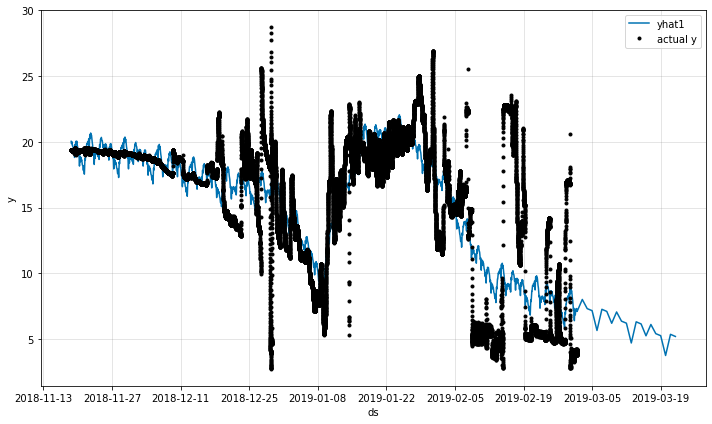

In [17]:
# fig_forecast = m.plot(forecast)

future = m.make_future_dataframe(df_a, periods=20, n_historic_predictions=True)
forecast = m.predict(future)
fig1 = m.plot(forecast)

## Entire dataset

In [18]:
df

,DeviceId,Temp
2018-11-18 16:12:19.437,A,19.41
2018-11-18 16:17:19.430,A,19.39
2018-11-18 16:22:19.433,A,19.37
2018-11-18 16:27:19.430,A,19.41
2018-11-18 16:32:19.427,A,19.39
...,...,...
2021-11-18 15:44:37.000,A,21.90
2021-11-18 15:49:37.000,A,21.83
2021-11-18 15:54:37.007,A,21.73
2021-11-18 15:59:36.997,A,21.64


In [19]:
df = df.drop(columns=["DeviceId"])
df["ds"] = df.index
df = df.rename(columns={"Temp": "y"})

In [20]:
m = NeuralProphet(n_changepoints=10,
                    changepoints_range=0.70,)
metrics = m.fit(df, freq="D")
metrics.head(3)

INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 32.137% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 128
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 20


  0%|          | 0/374 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.30E-02, min: 1.11E+00


  0%|          | 0/374 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.90E-02, min: 1.24E+00


  0%|          | 0/374 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.50E-01, min: 1.11E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.12E-02
Epoch[20/20]: 100%|██████████████████| 20/20 [01:19<00:00,  3.97s/it, SmoothL1Loss=0.0101, MAE=5.59, RMSE=8, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,0.213033,23.768804,30.136007,0.0
1,0.011146,6.030927,8.415788,0.0
2,0.012191,6.431212,8.809156,0.0


INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 32.137% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
WARNING - (py.warnings._showwarnmsg) - C:\Users\CybiW\anaconda3\lib\site-packages\neuralprophet\forecaster.py:1665: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 32.1% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq D. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils._infer_frequency) - Major frequency 

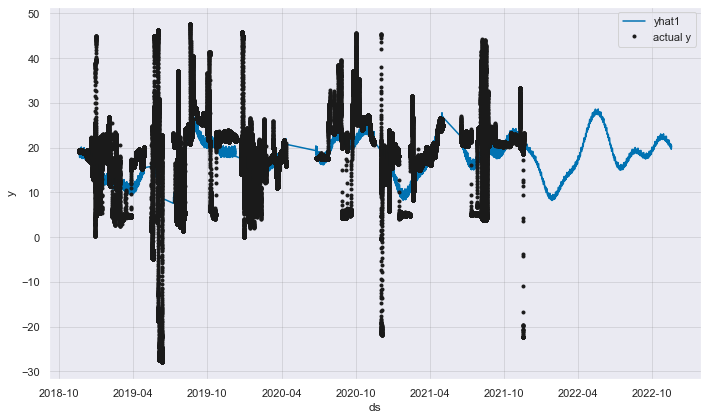

In [21]:
sns.set_theme()
future = m.make_future_dataframe(df, periods=365, n_historic_predictions=True)
forecast = m.predict(future)
fig1 = m.plot(forecast)

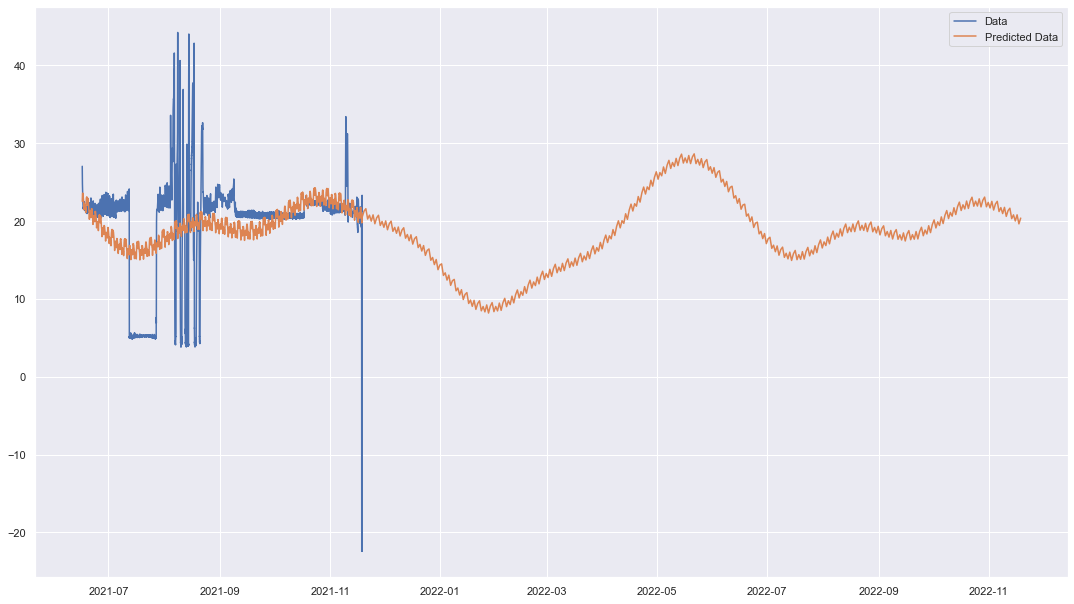

In [22]:
## Zoom on Prediction

### index time and look 
datetime_series = pd.to_datetime(forecast['ds'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
forecast=forecast.set_index(datetime_index)
forecast_pred = forecast.loc['2021-06-16':'2022-11-18']

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5, forward=True)
ax.plot(forecast_pred["ds"],forecast_pred["y"], label="Data")
ax.plot(forecast_pred["ds"],forecast_pred["yhat1"],label="Predicted Data")
ax.legend(loc = 'upper right')
plt.show()

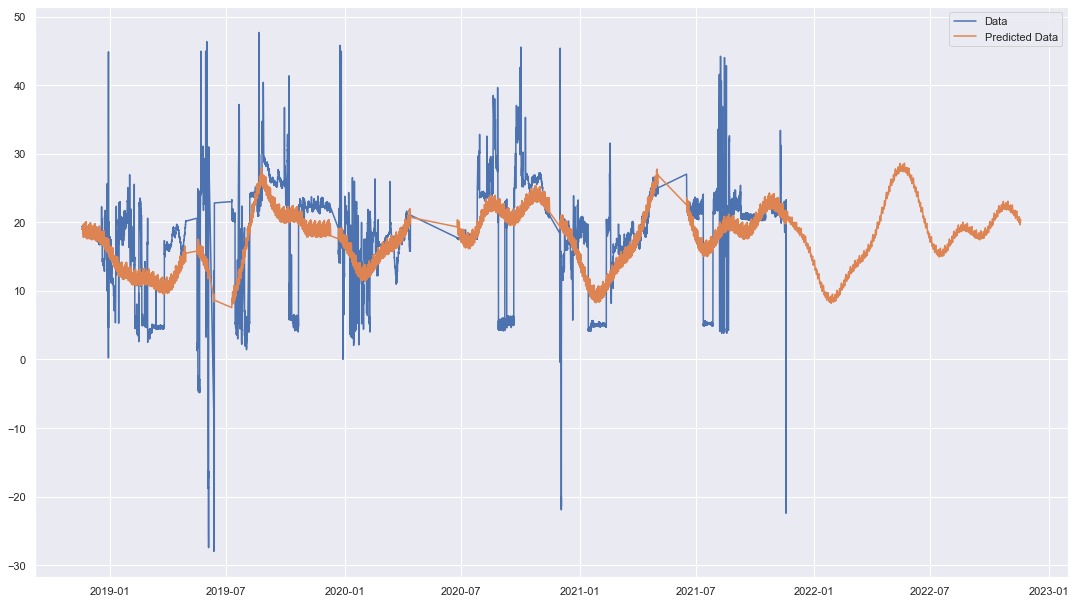

In [23]:
fig, ax = plt.subplots()
ax.plot(forecast.index,forecast["y"], label="Data")
ax.plot(forecast.index,forecast["yhat1"],label="Predicted Data")
ax.legend(loc = 'upper right')
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()